In [5]:
import re
import csv
import string
import math

import numpy as np
import pandas as pd
import scipy.stats as stats

In [6]:
data = pd.read_csv("/kaggle/input/tweet-data/labeled_data.csv")

# Clean the tweet text

In [8]:
!pip install tweet-preprocessor

In [10]:
import preprocessor as p

The dataset used for this project is obtained from the [Davidson et al. 2017](http://https://ojs.aaai.org/index.php/ICWSM/article/view/14955) paper. Their GitHub repo can be found [here](http://https://github.com/t-davidson/hate-speech-and-offensive-language). 

In [11]:
data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [12]:
# Remove url, emojis, mentions, numbers, and not hashtags
# p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.MENTION)
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.MENTION, p.OPT.NUMBER)

In [13]:
# Remove HTML codes for emojis
def remove_emojis(text_string) : 
#     emoji_regex = '&#[0-9]+;'
    emoji_regex = '&#\S*'
    parsed_text = re.sub(emoji_regex, "", text_string)
    return parsed_text

In [14]:
data['clean_tweet'] = data['tweet'].apply(remove_emojis)
data['clean_tweet'] = data['clean_tweet'].apply(p.clean)

In [15]:
data['clean_tweet'][0]

"!!! RT : As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [16]:
data['clean_tweet'].isnull().sum()

0

In [17]:
# Add label column 
data['label'] = data['class'].apply(lambda x: 0 if (x==1) | (x==2) else 1) # Hate speech as 1, Not hate speech as 0

In [18]:
data.head()

,count,hate_speech,offensive_language,neither,class,tweet,clean_tweet,label
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...,0
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...,0
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...,0
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT : she look like a tranny,0
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...,0


## Class distribution 

Dataset is unbalanced, we see very few samples of hate speech

In [19]:
data.groupby('label').size()

label
0    23353
1     1430
dtype: int64

<Axes: >

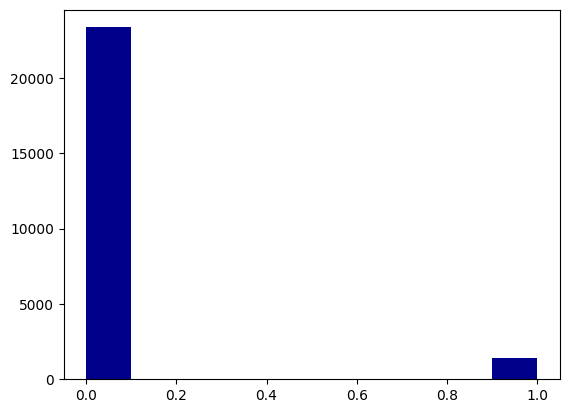

In [20]:
data['label'].hist(color='darkblue', grid=False)

Here, 0 = not hate speech, and 1 = hate speech

# Add AAVE annotation to dataset

## Prepare dataset for training

In [25]:
aave_csv = pd.read_csv("/kaggle/input/dialect-samples/aave_samples.csv",header=None)
sae_csv = pd.read_csv("/kaggle/input/dialect-samples/sae_samples.csv",header=None)

aave_csv.rename(columns = {0:'text'},inplace = True)
sae_csv.rename(columns = {0:'text'},inplace = True)

In [26]:
aave_csv['aave'] = 1
sae_csv['aave'] = 0

In [27]:
aave_csv.head()

,text,aave
0,Sooo Manti Te'o was having a online/phone rela...,1
1,this lil girl aint going to win im the king of...,1
2,He up stairs rights now and I'm down here gett...,1
3,Shit I Am Who Am..Fresh up out of Apologize..I...,1
4,It's very rare that I get what I want. Now tha...,1


In [28]:
sae_csv.head()

,text,aave
0,Manti Te'o was having a relationship via telep...,0
1,The little girl is not going to win because i ...,0
2,He is upstairs rights now and I'm down here ge...,0
3,"Shit, I am who I am. I'm done apologizing. I'm...",0
4,"It is very rare that I get what I want, but no...",0


In [31]:
len(aave_csv), len(sae_csv)

(2019, 2019)

In [30]:
dialect_data = pd.concat([aave_csv, sae_csv])
len(dialect_data)

4038

## Train Facebook's MBart model on the dialect dataset

In [1]:
from transformers import AutoModelForSeq2SeqLM, TrainingArguments, Trainer

model = AutoModelForSeq2SeqLM.from_pretrained('facebook/mbart-large-en-ro', device_map='auto')

2024-03-16 04:33:28.264859: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 04:33:28.264965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 04:33:28.420674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [3]:
training_args = TrainingArguments(
    output_dir='./results',          # directory for saving models and checkpoints
    num_train_epochs=5,              # number of training epochs, adjust as needed
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
)

## Add Classification Head on the MBart model

In [ ]:
# Save clean data to new file

